In [1]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F


In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/demouser/good_python/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
class HSGLayer(nn.Module):
    def __init__(self, n_units, init_gates_closed):
        super(HSGLayer, self).__init__()
        self.W_R = nn.Linear(n_units, n_units, bias=False)
        self.W_F = nn.Linear(n_units, n_units)
        if init_gates_closed:
            self.W_F.bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
    def forward(self, s_L_t, s_prime_tm1):
        g = torch.sigmoid(self.W_R(s_prime_tm1) + self.W_F(s_L_t))
        s_prime_t = g*s_prime_tm1 + (1 - g)*s_L_t
        return s_prime_t

class RHNCell(nn.Module):
    def __init__(self, in_feats, n_units, rec_depth=3, couple_gates=True,
                 use_HSG=False, init_gates_closed=False):
        super(RHNCell, self).__init__()
        self.rec_depth = rec_depth
        self.in_feats = in_feats
        self.n_units = n_units
        self.couple_gates = couple_gates
        self.use_HSG = use_HSG
        self.W_H = nn.Linear(in_feats, n_units, bias=False)
        self.W_T = nn.Linear(in_feats, n_units, bias=False)
        if not couple_gates:
            self.W_C = nn.Linear(in_feats, n_units, bias=False)
        self.R_H = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        self.R_T = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        if not couple_gates:
            self.R_C = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        
        if use_HSG:
            self.HSG = HSGLayer(n_units, init_gates_closed)
        
        if init_gates_closed:
            for l in range(rec_depth):
                self.R_T[l].bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
                if not couple_gates:
                    self.R_C[l].bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
        
    def forward(self, x, s):
        if self.use_HSG:
            s_prime_tm1 = s
        preds = []
        for l in range(self.rec_depth):
            if l == 0:
                h_l_t = torch.tanh(self.W_H(x) + self.R_H[l](s))
                t_l_t = torch.sigmoid(self.W_T(x) + self.R_T[l](s))
                if not self.couple_gates:
                    c_l_t = torch.sigmoid(self.W_C(x) + self.R_C[l](s))
            else:
                h_l_t = torch.tanh(self.R_H[l](s))
                t_l_t = torch.sigmoid(self.R_T[l](s))
                if not self.couple_gates:
                    c_l_t = torch.sigmoid(self.R_C[l](s))
            
            if not self.couple_gates:
                s = h_l_t*t_l_t + c_l_t*s
            else:
                s = h_l_t*t_l_t + (1 - t_l_t)*s
            preds.append(s)
                
        if self.use_HSG:
            s = self.HSG(s, s_prime_tm1)
            preds.pop()
            preds.append(s)
        preds = torch.stack(preds)
        return s, preds

    
class RHN(nn.Module):
    def __init__(self, in_feats, out_feats, n_units=32, rec_depth=3, couple_gates=True, use_HSG=False,
                 init_gates_closed=False, use_batch_norm=False):
        super(RHN, self).__init__()
        assert rec_depth > 0
        self.rec_depth = rec_depth
        self.in_feats = in_feats
        self.n_units = n_units
        self.init_gates_closed = init_gates_closed
        self.couple_gates = couple_gates
        self.use_HSG = use_HSG
        self.use_batch_norm = use_batch_norm
        self.RHNCell = RHNCell(in_feats, n_units, rec_depth, couple_gates=couple_gates,
                               use_HSG=use_HSG, init_gates_closed=init_gates_closed)
        if use_batch_norm:
            self.bn_x = nn.BatchNorm1d(in_feats)
            self.bn_s = nn.BatchNorm1d(n_units)
    def forward(self, x):
        s = torch.zeros(x.shape[0], self.n_units).cuda()
        preds = []
        highway_states = []
        for t in range(x.shape[1]):
            if self.use_batch_norm:
                x_inp = self.bn_x(x[:, t, :])
                s = self.bn_s(s)
            else:
                x_inp = x[:, t, :]
            s, all_s = self.RHNCell(x_inp, s)
            preds.append(s)
            highway_states.append(all_s)
        preds = torch.stack(preds)
        preds = preds.permute(1, 0, 2)
        highway_states = torch.stack(highway_states)
        highway_states = highway_states.permute(2, 0, 3, 1)
        out = preds
        
        return out, highway_states

class ConvBlock(nn.Module):
    def __init__(self, T, in_channels, n_filters=32, filter_size=5):
        super(ConvBlock, self).__init__()
        padding1 = self._calc_padding(T, filter_size)
        self.conv = nn.Conv1d(in_channels, n_filters, filter_size, padding=padding1)
        self.relu = nn.ReLU()
        self.maxpool = nn.AdaptiveMaxPool1d(T)
        self.zp = nn.ConstantPad1d((1, 0), 0)
    def _calc_padding(self, Lin, kernel, stride=1, dilation=1):
        p = int(((Lin - 1) * stride + 1 + dilation * (kernel - 1) - Lin) / 2)
        return p
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        return x
    
    
class HARHN(nn.Module):
    def __init__(self, n_conv_layers, T, in_feats, target_feats, n_units_enc=32, n_units_dec=32, enc_input_size=32, rec_depth=3,
                 out_feats=1, n_filters=32, filter_size=5):
        super(HARHN, self).__init__()
        assert n_conv_layers > 0
        self.n_convs = n_conv_layers
        self.n_units_enc = n_units_enc
        self.n_units_dec = n_units_dec
        self.rec_depth = rec_depth
        self.T = T
        self.convs = nn.ModuleList([ConvBlock(T, in_feats, n_filters=n_filters, filter_size=filter_size) if i == 0 else ConvBlock(T, n_filters, n_filters=n_filters, filter_size=filter_size) for i in range(n_conv_layers)])
        self.conv_to_enc = nn.Linear(n_filters, enc_input_size)
        self.RHNEncoder = RHN(enc_input_size, out_feats=n_units_enc, n_units=n_units_enc, rec_depth=rec_depth)
        self.RHNDecoder = RHNCell(target_feats, n_units_dec, rec_depth=rec_depth)
        self.T_k = nn.ModuleList([nn.Linear(n_units_dec, n_units_enc, bias=False) for i in range(self.rec_depth)])
        self.U_k = nn.ModuleList([nn.Linear(n_units_enc, n_units_enc) for i in range(self.rec_depth)])
        self.v_k = nn.ModuleList([nn.Linear(n_units_enc, 1) for i in range(self.rec_depth)])
        self.W_tilda = nn.Linear(target_feats, target_feats, bias=False)
        self.V_tilda = nn.Linear(rec_depth*n_units_enc, target_feats)
        self.W = nn.Linear(n_units_dec, target_feats)
        self.V = nn.Linear(rec_depth*n_units_enc, target_feats)
    def forward(self, x, y):
        for l in range(self.n_convs):
            x = self.convs[l](x)
        x = self.conv_to_enc(x)
        x, h_T_L = self.RHNEncoder(x) # h_T_L.shape = (batch_size, T, n_units_enc, rec_depth)
        s = torch.zeros(x.shape[0], self.n_units_dec).cuda()
        for t in range(self.T):
            s_rep = s.unsqueeze(1)
            s_rep = s_rep.repeat(1, self.T, 1)
            d_t = []
            for k in range(self.rec_depth):
                h_T_k = h_T_L[..., k]
                a = self.U_k[k](h_T_k)
                b = self.T_k[k](s_rep)
                e_t_k = self.v_k[k](torch.tanh(self.T_k[k](s_rep) + self.U_k[k](h_T_k)))
                alpha_t_k = torch.softmax(e_t_k, 1)
                d_t_k = torch.sum(h_T_k*alpha_t_k, dim=1)
                d_t.append(d_t_k)
            d_t = torch.cat(d_t, dim=1)
            y_tilda_t = self.W_tilda(y[:, t, :]) + self.V_tilda(d_t)
            s, _ = self.RHNDecoder(y_tilda_t, s)
        
        y_T = self.W(s) + self.V(d_t)
        return y_T

In [5]:
data = pd.read_csv("nasdaq100_padding.csv")

In [6]:
data.shape

(40560, 82)

In [7]:
data.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


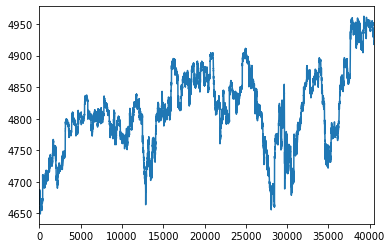

In [8]:
data["NDX"].plot()

In [9]:
batch_size = 128
timesteps = 16
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [10]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [11]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [12]:
for j in range(timesteps):
    y[:, j, 0] = data["NDX"].shift(timesteps - j - 1).fillna(method="bfill")

In [13]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [14]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [15]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [16]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [17]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

### DARNN

In [18]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [19]:
model = HARHN(3, X_train.shape[1], X_train.shape[2], 1, n_units_enc=64, n_units_dec=64).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [21]:
from torch.utils.data import TensorDataset, DataLoader
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=128)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Saving...
Iter:  0 train:  0.058557320678932594 val:  0.009696790653504647
mse:  6.4715595 mae:  1.609681


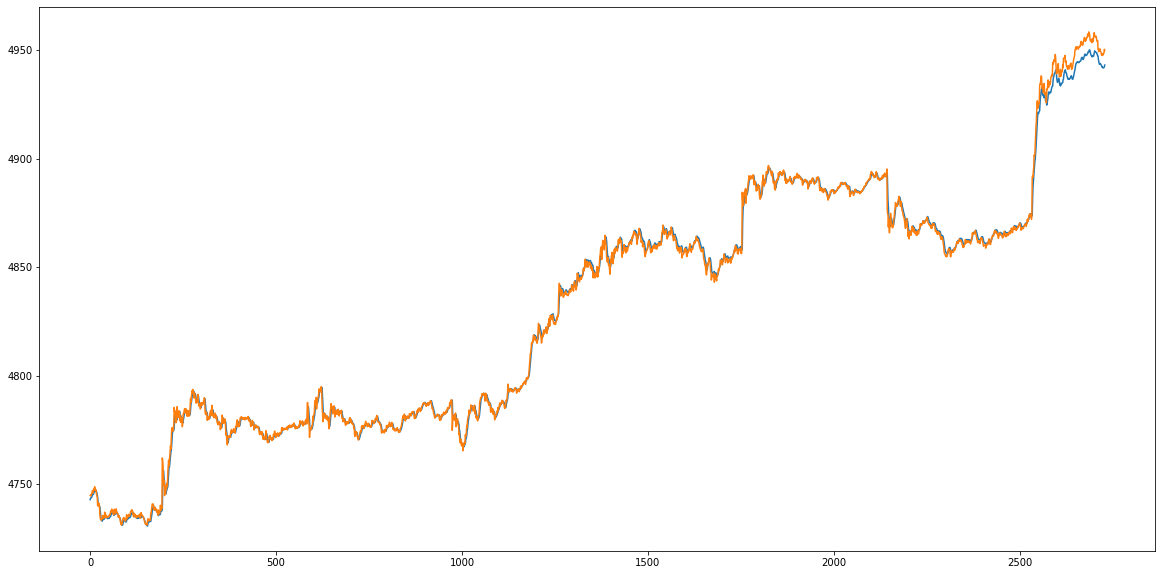

Saving...
Iter:  1 train:  0.008288481298779776 val:  0.009245028379994163
Iter:  2 train:  0.008102489622331928 val:  0.011655775242840408
Saving...
Iter:  3 train:  0.008009247922642843 val:  0.008269697338831015
Iter:  4 train:  0.007679386302388256 val:  0.013253075676111246
Iter:  5 train:  0.007804875742455771 val:  0.01038557920312263
Saving...
Iter:  6 train:  0.007627851233877709 val:  0.007266937921923602
Iter:  7 train:  0.00756767121177385 val:  0.007274513649157184
Iter:  8 train:  0.00782503917232948 val:  0.012125137869646677
Saving...
Iter:  9 train:  0.007392066270626533 val:  0.006935428930428847
Iter:  10 train:  0.007060111193077332 val:  0.007181320112913013
mse:  3.5494435 mae:  1.2537569


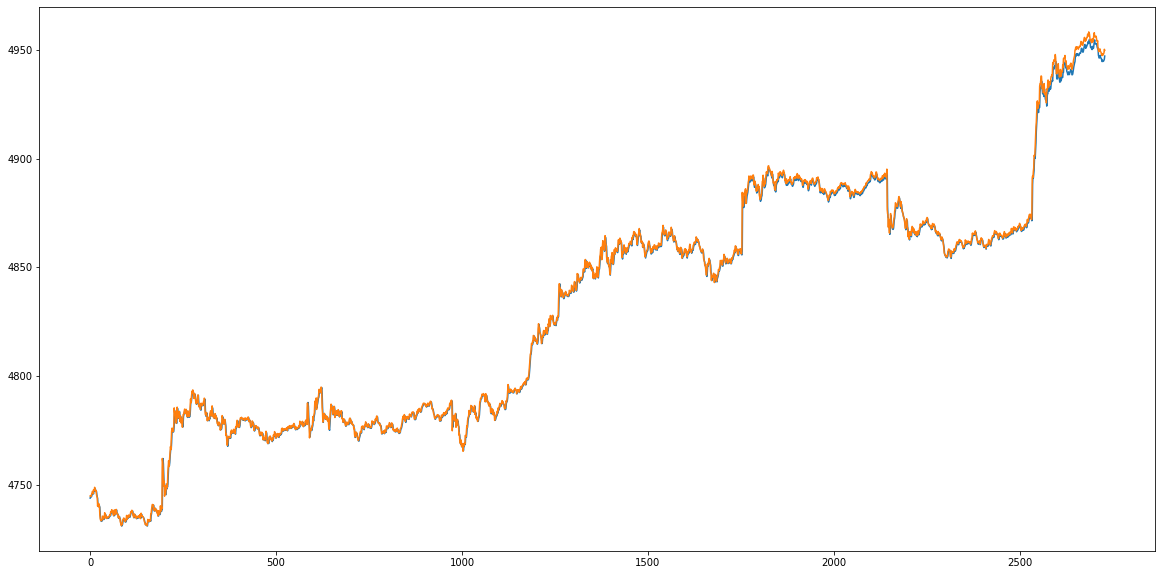

Saving...
Iter:  11 train:  0.00734263022224129 val:  0.006492022046759097
Iter:  12 train:  0.007310613417575684 val:  0.006855356413162332
Iter:  13 train:  0.007171462098787902 val:  0.007554539651965806
Iter:  14 train:  0.007225652772743511 val:  0.007862882946486108
Iter:  15 train:  0.007512954739791833 val:  0.006517329238077802
Iter:  16 train:  0.007295788440190965 val:  0.007233311434904842
Iter:  17 train:  0.0074023444701813105 val:  0.006605596105994858
Saving...
Iter:  18 train:  0.0071730334787711465 val:  0.006408479211033392
Saving...
Iter:  19 train:  0.007352891522325489 val:  0.006287207574699069
Iter:  20 train:  0.006928538688568339 val:  0.013011727525882633
mse:  11.652547 mae:  3.001045


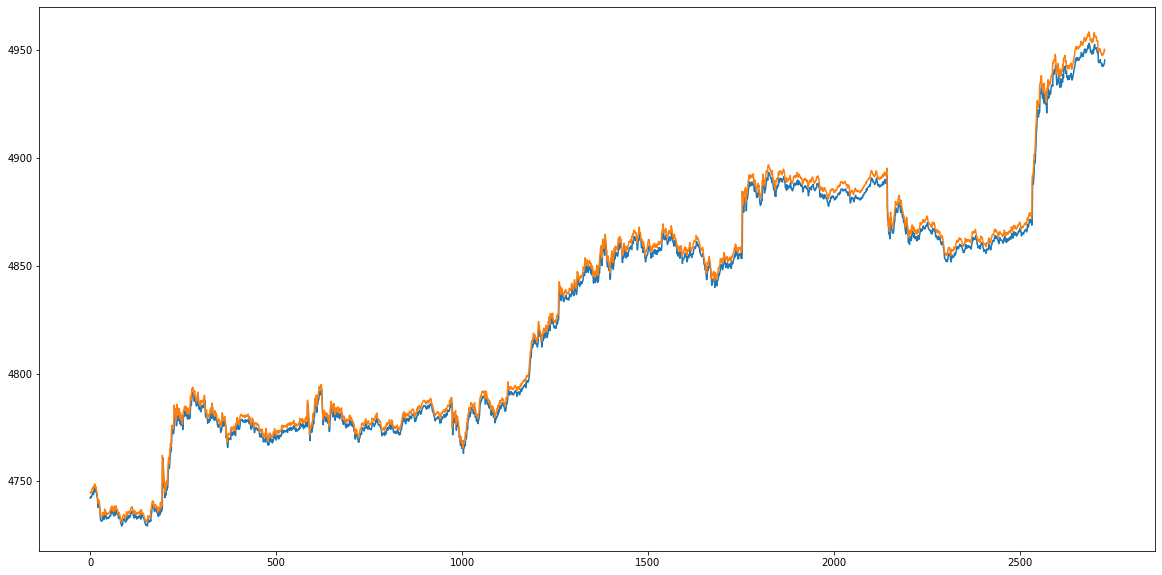

Iter:  21 train:  0.007101763458663246 val:  0.006603568934281228
Iter:  22 train:  0.006935979233286119 val:  0.006944748013592763
Iter:  23 train:  0.006992268332469404 val:  0.013114480796136719
Iter:  24 train:  0.007206581462195383 val:  0.006590762598082755
Iter:  25 train:  0.006895992444934208 val:  0.006324982756524401
Iter:  26 train:  0.007144846566097987 val:  0.006500990274480543
Iter:  27 train:  0.006935079057807887 val:  0.006339031321544232
Iter:  28 train:  0.007133798365534484 val:  0.006547807604188645
Iter:  29 train:  0.007077217269201931 val:  0.006445208985264513
Iter:  30 train:  0.006898645154043189 val:  0.007098707595357254
mse:  3.4682498 mae:  1.2630792


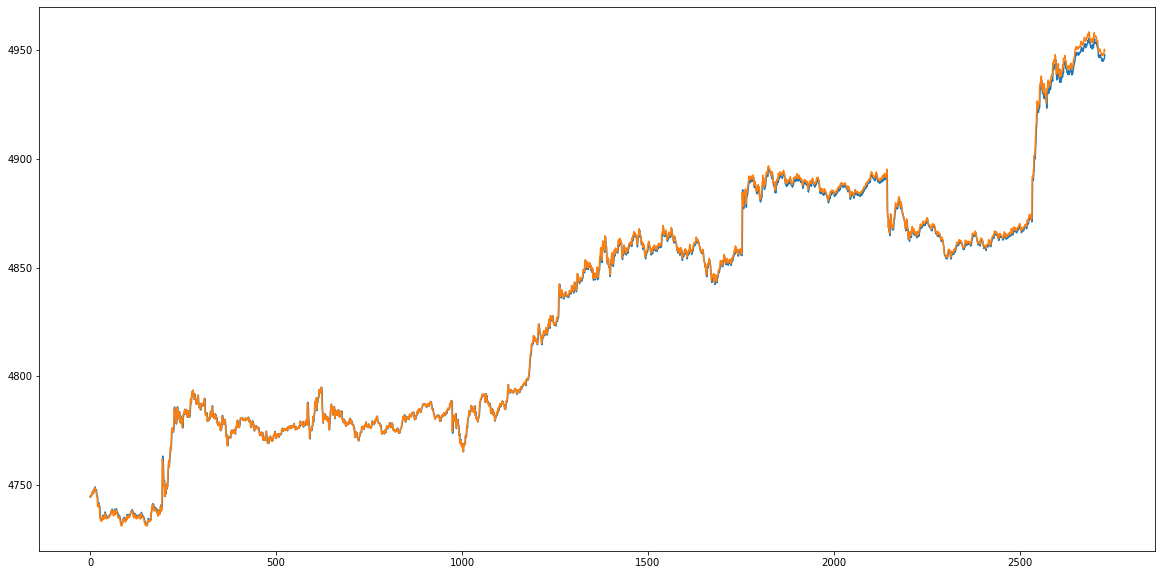

Iter:  31 train:  0.006917249420941571 val:  0.010209414277879294
Iter:  32 train:  0.007153716451892859 val:  0.006353916928117494
Iter:  33 train:  0.007106860457886354 val:  0.007517900410145776


In [24]:
epochs = 150
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "harhn_nasdaq.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [25]:
model.load_state_dict(torch.load("harhn_nasdaq.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [26]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

/home/demouser/good_python/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/demouser/good_python/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [27]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [28]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [29]:
mse, mae

(3.2031612, 1.3878716)

In [30]:
mse, mae

(3.2031612, 1.3878716)

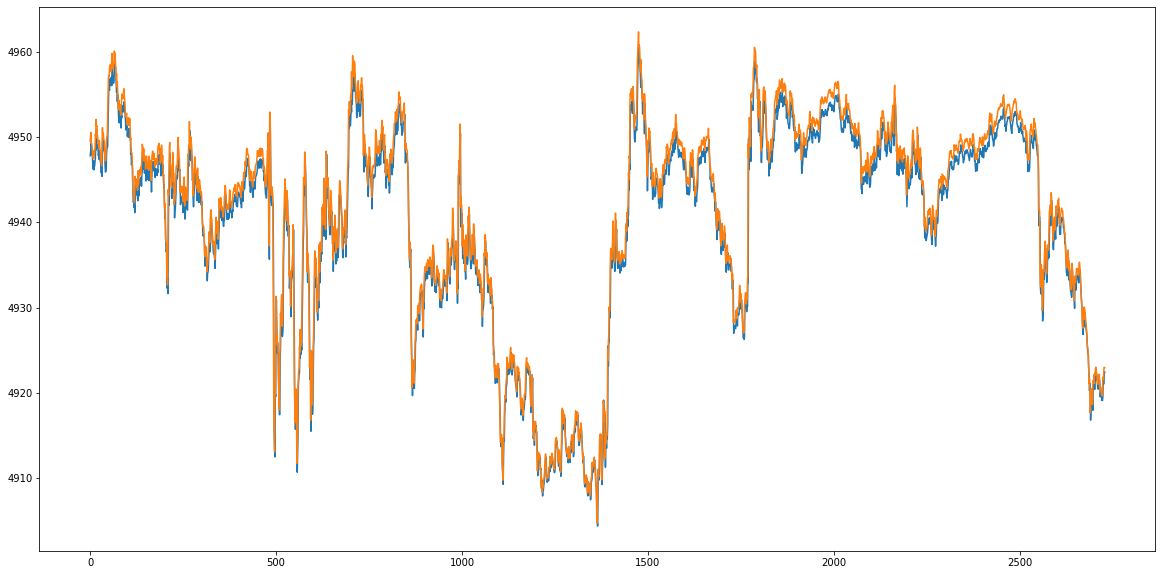

In [31]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()